In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

from sklearn import metrics

from sklearn import linear_model 

from skopt import gp_minimize
from multiprocessing import Pool

import pickle

%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [13]:
# functions needed for later
def laged_features(data, max_laggs):
    df = data.copy()
    for col in df.columns:
        for l in range(1, max_laggs):
            df.loc[:,f'{col}_lag_{l}'] = df[col].shift(l)
    return df

# Load data

In [3]:
# load count data
counts_df = pd.read_csv('../data/count_data.csv')
counts_df['date'] = pd.to_datetime(counts_df['date'])
# do days since
counts_df['days_since_start'] = (counts_df['date'] -counts_df['date'].min()).dt.days
counts_df

,week,green,colour_break_1,colour_break_2,pink,cherry,blue,year,date,days_since_start
0,39,660,327,65,19,29,54,2018,2018-09-27,0
1,40,600,292,65,18,23,109,2018,2018-10-01,4
2,41,532,240,85,25,18,65,2018,2018-10-08,11
3,43,415,162,57,17,15,40,2018,2018-10-22,25
4,44,468,125,49,12,13,18,2018,2018-10-29,32
5,45,490,121,41,12,10,20,2018,2018-11-05,39
6,46,502,105,32,9,7,22,2018,2018-11-12,46
7,48,555,137,26,9,5,10,2018,2018-11-26,60
8,49,654,150,30,7,4,4,2018,2018-12-03,67
9,50,662,155,26,6,6,16,2018,2018-12-10,74


In [4]:
# load weight data
weight_df = pd.read_csv('../data/weight_data.csv')
#weight_df['date'] = pd.to_datetime(weight_df['date'])
weight_df

,week,weight
0,39,1.74
1,40,1.63
2,41,1.78
3,43,1.54
4,44,1.50
5,45,1.42
6,46,1.41
7,48,1.61
8,49,1.52
9,50,1.71


# Data Analyisis

In [6]:
counts_df.corr()

,week,green,colour_break_1,colour_break_2,pink,cherry,blue,year,days_since_start
week,1.000000,0.070007,-0.713879,0.000372,0.139954,0.030396,-0.079987,-0.982233,-0.713403
green,0.070007,1.000000,-0.145797,-0.165221,-0.228919,-0.218414,0.008653,-0.087530,-0.122015
colour_break_1,-0.713879,-0.145797,1.000000,0.373825,0.293692,0.521233,0.467702,0.662044,0.369358
colour_break_2,0.000372,-0.165221,0.373825,1.000000,0.957840,0.821891,0.713786,-0.145895,-0.542913
pink,0.139954,-0.228919,0.293692,0.957840,1.000000,0.822568,0.662796,-0.283869,-0.645172
cherry,0.030396,-0.218414,0.521233,0.821891,0.822568,1.000000,0.747180,-0.168711,-0.532986
blue,-0.079987,0.008653,0.467702,0.713786,0.662796,0.747180,1.000000,-0.045521,-0.406298
year,-0.982233,-0.087530,0.662044,-0.145895,-0.283869,-0.168711,-0.045521,1.000000,0.832204
days_since_start,-0.713403,-0.122015,0.369358,-0.542913,-0.645172,-0.532986,-0.406298,0.832204,1.000000


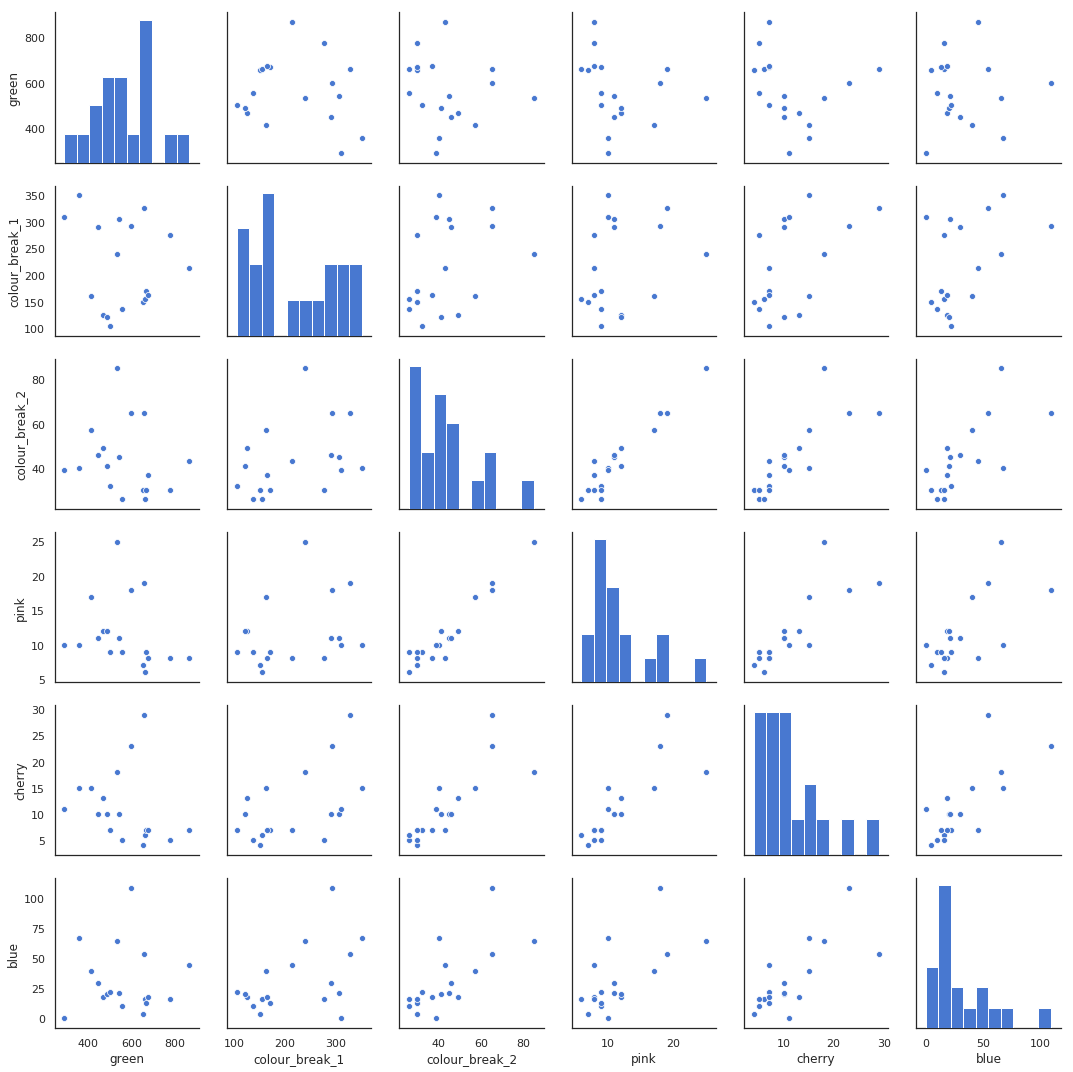

In [8]:
sns.pairplot(counts_df[['green','colour_break_1','colour_break_2','pink','cherry','blue']])

Seems like color_break_2, pink, cherry, and blue are highly correlated with eachother while green and color_break_1  weakly correlated 

## look at lagged windows to see if lagged correlation

In [11]:
# resample so steps are even
resampled_counts_df = counts_df.iloc[1:].set_index('date').resample('W-MON').interpolate('spline',order=1)
# drop last period since after observation window
resampled_counts_df =resampled_counts_df.round().iloc[:-1]

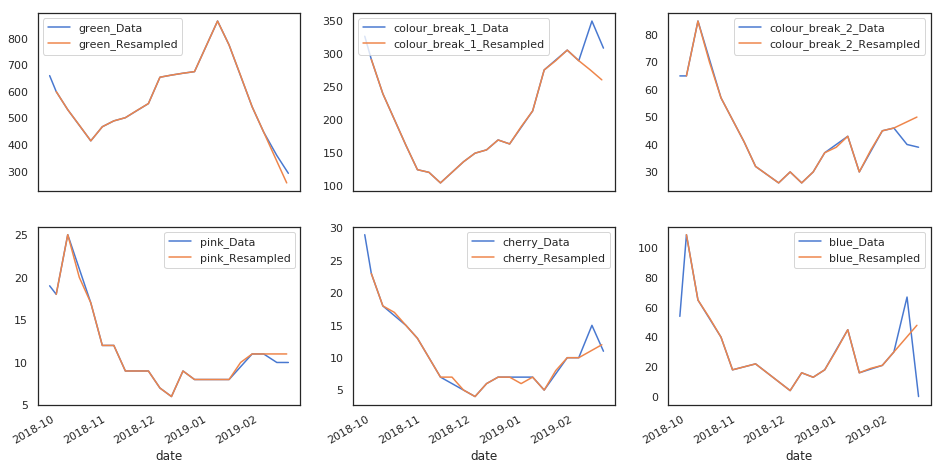

In [12]:
# plot
fig, *ax = plt.subplots(2,3, figsize=(16,8),sharex=True)
ax =np.ravel(ax)
for i, col in enumerate(['green','colour_break_1','colour_break_2','pink','cherry','blue']):
    counts_df.plot(x='date',y=col,ax=ax[i])
    resampled_counts_df[col].plot(ax=ax[i])
    ax[i].legend((f'{col}_Data', f'{col}_Resampled'))

In [17]:
# create lagged array
col = ['green', 'colour_break_1', 'colour_break_2', 'pink', 'cherry', 'blue']
lagged_df = laged_features(resampled_counts_df[col],5)
#lagged_df = lagged_df.drop(columns=['blue'])
lagged_df.corr()

,green,colour_break_1,colour_break_2,pink,cherry,blue,green_lag_1,green_lag_2,green_lag_3,green_lag_4,...,pink_lag_3,pink_lag_4,cherry_lag_1,cherry_lag_2,cherry_lag_3,cherry_lag_4,blue_lag_1,blue_lag_2,blue_lag_3,blue_lag_4
green,1.000000,-0.034870,-0.367661,-0.393205,-0.446435,-0.174256,0.875739,0.570332,0.191414,-0.162862,...,-0.468689,-0.361094,-0.535466,-0.534486,-0.493304,-0.348414,-0.256621,-0.343711,-0.412723,-0.412406
colour_break_1,-0.034870,1.000000,0.381960,0.239350,0.337430,0.462070,0.349824,0.682057,0.858594,0.881089,...,-0.565075,-0.686649,-0.006319,-0.306776,-0.516388,-0.666660,0.223393,-0.006556,-0.208796,-0.388131
colour_break_2,-0.367661,0.381960,1.000000,0.942826,0.900157,0.787170,-0.252480,-0.038904,0.382616,0.725765,...,0.325706,-0.089794,0.896713,0.734332,0.395781,-0.028829,0.880916,0.773499,0.578966,0.315878
pink,-0.393205,0.239350,0.942826,1.000000,0.888913,0.710816,-0.277323,-0.147468,0.114720,0.438565,...,0.575492,0.359912,0.940774,0.853382,0.710634,0.392073,0.901045,0.890752,0.838951,0.586294
cherry,-0.446435,0.337430,0.900157,0.888913,1.000000,0.867396,-0.437345,-0.204699,0.155718,0.494760,...,0.557104,0.195416,0.925776,0.807013,0.604400,0.269413,0.805600,0.788423,0.710266,0.571578
blue,-0.174256,0.462070,0.787170,0.710816,0.867396,1.000000,-0.184482,-0.046021,0.263871,0.574804,...,0.000611,-0.308530,0.710898,0.498646,0.154424,-0.322133,0.789626,0.504781,0.177810,-0.138057
green_lag_1,0.875739,0.349824,-0.252480,-0.277323,-0.437345,-0.184482,1.000000,0.848725,0.515514,0.152601,...,-0.626333,-0.553079,-0.458172,-0.580750,-0.604153,-0.561572,-0.110784,-0.246629,-0.391724,-0.527710
green_lag_2,0.570332,0.682057,-0.038904,-0.147468,-0.204699,-0.046021,0.848725,1.000000,0.836975,0.515391,...,-0.661848,-0.698384,-0.412547,-0.477720,-0.630646,-0.658171,-0.069312,-0.083362,-0.269212,-0.471750
green_lag_3,0.191414,0.858594,0.382616,0.114720,0.155718,0.263871,0.515514,0.836975,1.000000,0.843465,...,-0.539775,-0.696968,-0.152180,-0.399501,-0.494759,-0.654071,0.077261,-0.013738,-0.086353,-0.307660
green_lag_4,-0.162862,0.881089,0.725765,0.438565,0.494760,0.574804,0.152601,0.515391,0.843465,1.000000,...,-0.321708,-0.546471,0.203030,-0.134898,-0.395882,-0.496854,0.373012,0.117879,-0.005070,-0.097846


Seems like green and color_break_1 have correlation after a few weeks

# Model

The model, models the process of a berry as it goes through the different ripening stages. The berry has 3 transition states: change color, get lost, stay the same color that can change at every step. Each step is a day so observations can be irregular.

The optimization The starting population age for each state, assuming the age is drawn from a normal distribution

In [135]:
class BerryHMMModel(object):
    _cols = ['green', 'colour_break_1', 'colour_break_2', 'pink', 'cherry', 'blue']
    def __init__(self,y_df: pd.DataFrame, verbose: bool = True):
        self.y_df = y_df
        self._verbose = verbose
        
    def unwrap(self, *param):
        param = np.asarray(param)
        ripen = dict()
        for state,l in zip(self._cols, param[6:11]):
            ripen[state] = l
        loose = dict()
        for state,r in zip(self._cols, param[:6]):
            loose[state] = r
        lam = param[-1]
        return loose, ripen, lam
    
    def evaluate(self, days_since,init_params, loose, ripen, lam):
        # iterate over days
        y_hat = [init_params]
        for days_since in range(1, counts_df.days_since_start.max()+1):
            next_step = dict()
            transition = 0
            for state in loose:
                # new berrys
                if state == 'green':
                    transition = stats.poisson.rvs(lam)
                # loose
                temp_n_berries = y_hat[-1][state] - (loose[state] * y_hat[-1][state])
                #transition
                if state != 'blue':
                    next_transition = temp_n_berries *ripen[state]

                    temp_n_berries = temp_n_berries - next_transition
                # get berries
                temp_n_berries += transition
                # set transition for next step
                transition = next_transition + 0
                next_step[state] = temp_n_berries
            # pick berries
            if days_since % 7 == 0:
                next_step['picked'] = next_step['blue'] + 0
                next_step['blue'] = 0
            next_step['days_since_start'] = days_since
            y_hat.append(next_step)
        # calculate picked
        y_hat = pd.DataFrame(y_hat)
        y_hat.picked = y_hat.picked.fillna(0).cumsum()
        return y_hat
    
    def minimize(self, *params):
        loose, ripen, lam = self.unwrap(*param)
        init_params = self.y_df[self._cols].iloc[0].to_dict()
        y_hat = self.evaluate(self.y_df['days_since_start'],init_params, loose, ripen, lam)
        return np.nanmean(((y_hat.set_index('days_since_start') - self.y_df.set_index('days_since_start')) ** 2).values.ravel())

In [136]:
init_params = dict()
init_params.update(counts_df[['green', 'colour_break_1', 'colour_break_2', 'pink', 'cherry', 'blue']].iloc[0].to_dict())
init_params['days_since_start'] = 0

In [142]:
lam = 100
loose = dict()
loose['green'] =.5
loose['colour_break_1']=.5
loose['colour_break_2']=.5
loose['pink']=.5
loose['cherry']=.5
loose['blue']=.5
# transition per day
ripen = dict()
ripen['green'] =1/21.
ripen['colour_break_1']=1/18.
ripen['colour_break_2']=1/11.
ripen['pink']=1/5.
ripen['cherry']=1/3.
# stay = 1 - loose - ripen


,green,colour_break_1,colour_break_2,pink,cherry,blue,days_since_start,picked
0,660.000000,327.000000,65.000000,19.000000,29.000000,54.000000,0,0.000000
1,408.285714,170.130952,38.628788,10.554545,11.566667,31.833333,1,0.000000
2,305.421769,90.060705,22.284400,5.977672,4.911010,17.844444,2,0.000000
3,250.438937,49.800613,12.630959,3.403996,2.234771,9.740724,3,0.000000
4,221.256637,29.479788,7.124695,1.935733,1.085323,5.242824,4,0.000000
...,...,...,...,...,...,...,...,...
141,191.273989,8.493708,0.424376,0.033400,0.005155,0.000854,141,0.831063
142,184.082852,8.565060,0.428835,0.032650,0.005058,0.001286,142,0.831063
143,190.658501,8.427537,0.432843,0.032552,0.004951,0.001486,143,0.831063
144,193.789762,8.519158,0.430845,0.032696,0.004906,0.001568,144,0.831063


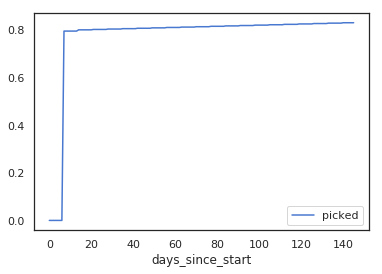

In [146]:
model = BerryHMMModel(counts_df)
result_df = model.evaluate(counts_df.days_since_start, init_params, loose, ripen, lam)
result_df.plot(x='days_since_start', y='picked')
result_df

In [139]:
param = list(loose.values()) + list(ripen.values()) + [lam]
model.minimize(*param)

46778.88382098726

In [140]:
param_list = [(0,1.), (0,1.),(0,1.),(0,1.),(0,1.),(0,1.),
              (0,1.),(0,1.),(0,1.),(0,1.),(0,1.),
             (0,100)]


In [147]:
out = gp_minimize(model.minimize,param_list,n_calls=100,verbose=True,n_jobs=8)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0584
Function value obtained: 47406.9254
Current minimum: 47406.9254
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0381
Function value obtained: 47709.6197
Current minimum: 47406.9254
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0275
Function value obtained: 47511.4356
Current minimum: 47406.9254
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0367
Function value obtained: 47422.4196
Current minimum: 47406.9254
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0362
Function value obtained: 47359.8561
Current minimum: 47359.

1548.154192359897


,green,colour_break_1,colour_break_2,pink,cherry,blue,picked
days_since_start,,,,,,,
0,660.0,327.0,65.0,19.0,29.0,54.0,0.0
4,0.0,13.0,11.0,10.0,2.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,0.0,0.0,0.0,0.0,0.0,0.0,0.0


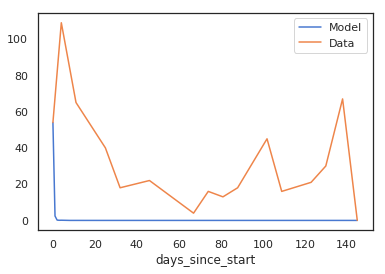

In [158]:
fig, ax = plt.subplots()
loose, ripen, lam = model.unwrap(*out.x)
result_df = model.evaluate(counts_df.days_since_start, init_params, loose, ripen, lam)
result_df.plot(x='days_since_start', y='blue',ax=ax)
counts_df.plot(x='days_since_start', y='blue',ax=ax)
plt.legend(('Model','Data'))
print(metrics.mean_squared_error(counts_df.set_index('days_since_start').blue, result_df.set_index('days_since_start').loc[counts_df.set_index('days_since_start').index].blue))
result_df.set_index('days_since_start').loc[counts_df.set_index('days_since_start').index].round()

In [150]:
result_df.round()

,green,colour_break_1,colour_break_2,pink,cherry,blue,days_since_start,picked
0,660.0,327.0,65.0,19.0,29.0,54.0,0,0.0
1,1.0,156.0,105.0,23.0,4.0,2.0,1,0.0
2,0.0,68.0,56.0,37.0,2.0,0.0,2,0.0
3,0.0,29.0,25.0,22.0,3.0,0.0,3,0.0
4,0.0,13.0,11.0,10.0,2.0,0.0,4,0.0
...,...,...,...,...,...,...,...,...
141,0.0,0.0,0.0,0.0,0.0,0.0,141,0.0
142,0.0,0.0,0.0,0.0,0.0,0.0,142,0.0
143,0.0,0.0,0.0,0.0,0.0,0.0,143,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,144,0.0


Doesn't seem like this model can recreate the data well since the loss doesn't change much from the start